<a href="https://colab.research.google.com/github/tatiana-iazykova/2020_HACK_RUSSIANSUPERGLUE/blob/main/RSG_RWSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
%%capture
%%bash
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://russiansuperglue.com/tasks/download/RWSD" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip
rm -r data/__MACOSX
rm -r sample_data/

# English counterpart of RWSD: The Winograd Schema Challenge
%%capture
%%bash
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://dl.fbaipublicfiles.com/glue/superglue/data/v2/WSC.zip" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip

In [2]:
# Load necessary code files and models from https://github.com/RussianNLP/RussianSuperGLUE 
# to recreate TfIdf baseline

%%capture
%%bash
# load tfidf pickle created by RSG team
wget -q --show-progress "https://russiansuperglue.com/tasks/tf_idf" -O temp.zip
unzip temp.zip -d data
rm temp.zip

# Make sure you donwload with the raw file link
# Keep the link relevant to your dataset
wget -q --show-progress "https://github.com/RussianNLP/RussianSuperGLUE/raw/master/tfidf_baseline/RWSD.py" -O RWSD.py

In [3]:
%%capture
%%bash
# add tree package for fancy directory display
apt-get install tree

In [4]:
# display the content of the folder
!tree

.
├── data
│   ├── RWSD
│   │   ├── test.jsonl
│   │   ├── train.jsonl
│   │   └── val.jsonl
│   ├── tfidf.pkl
│   └── WSC
│       ├── test.jsonl
│       ├── train.jsonl
│       └── val.jsonl
└── RWSD.py

3 directories, 8 files


In [5]:
import pandas as pd
import json
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 80)

class JSONL_handler():
    """ opens a jsonl file and turns it into a necessary data structure """
    
    def __init__(self, path):
        self.path = path # path to jsonl file

    def to_pandas(self):
        """ get jsonl file content as a pandas DataFrame"""

        data = self.read_jsonlines()

        return pd.json_normalize(data).drop(columns=['idx'])

    
    def read_jsonlines(self):
        """ yields json lines one by one """
        data = []
        with open(self.path) as f:
            for line in f:
                data.append(json.loads(line))

        return data

# Explore Train and Val Data

In [6]:
# train dataset
handler = JSONL_handler('data/RWSD/train.jsonl')
df = handler.to_pandas()
handler_en = JSONL_handler('data/WCS/train.jsonl')
df_en = handler.to_pandas()

# val dataset
val_handler = JSONL_handler('data/RWSD/val.jsonl')
val_df = val_handler.to_pandas()
val_handler_en = JSONL_handler('data/WSC/val.jsonl')
val_df_en = val_handler_en.to_pandas()

In [7]:
df.head()

,label,text,target.span1_text,target.span2_text,target.span1_index,target.span2_index
0,True,"Члены городского совета отказали организаторам митинга в разрешении, потому что они опасались насилия.",Члены городского совета,они опасались,0,10
1,False,"Члены городского совета отказали организаторам митинга в разрешении, потому что они опасались насилия.",организаторам митинга,они опасались,4,10
2,False,"Члены городского совета отказали организаторам митинга в разрешении, потому что они одобряли насилие.",Члены городского совета,они одобряли,0,10
3,True,"Члены городского совета отказали организаторам митинга в разрешении, потому что они одобряли насилие.",организаторам митинга,они одобряли,4,10
4,True,"Кубок не помещается в коричневый чемодан, потому что он слишком большой.",Кубок,он слишком большой,0,8


In [8]:
import matplotlib.pyplot as plt

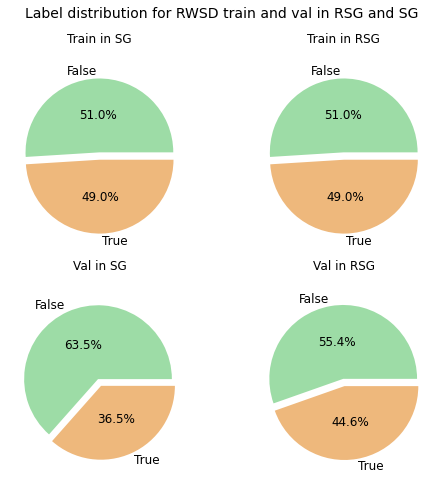

In [9]:
colours = {'#9ddca6', '#f0afb6', '#eeb87c'}

fig, axs = plt.subplots(2, 2, figsize=(7,7))
fig.suptitle('Label distribution for RWSD train and val in RSG and SG',
             fontsize=14)

axs[0, 0].pie(df_en['label'].value_counts(), autopct="%.1f%%",
              explode=[0.05]*2, labels=df_en['label'].value_counts().keys(),
              pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)
axs[0, 0].set_title('Train in SG\n', fontsize=12)

axs[0, 1].pie(df['label'].value_counts(), autopct="%.1f%%",
              explode=[0.05]*2, labels=df['label'].value_counts().keys(),
              pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)
axs[0, 1].set_title('Train in RSG\n', fontsize=12)

axs[1, 0].pie(val_df_en['label'].value_counts(),
              autopct="%.1f%%", explode=[0.05]*2,
              labels=val_df_en['label'].value_counts().keys(),
              pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)
axs[1, 0].set_title('Val in SG\n', fontsize=12)

axs[1, 1].pie(val_df['label'].value_counts(),
              autopct="%.1f%%", explode=[0.05]*2,
              labels=val_df['label'].value_counts().keys(),
              pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)
axs[1, 1].set_title('Val in RSG\n', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
df.iloc[10:20]

,label,text,target.span1_text,target.span2_text,target.span1_index,target.span2_index
10,False,"Женя поблагодарила Сашу за помощь, которую она оказала.",Женя,она оказала,0,6
11,True,"Женя поблагодарила Сашу за помощь, которую она оказала.",Сашу,она оказала,2,6
12,True,"Павел звонил Георгию по телефону, но он не дозвонился.",Павел,он не дозвонился,0,6
13,False,"Павел звонил Георгию по телефону, но он не дозвонился.",Георгию,он не дозвонился,2,6
14,False,"Павел звонил Георгию по телефону, но он не ответил.",Павел,он не ответил,0,6
15,True,"Павел звонил Георгию по телефону, но он не ответил.",Георгию,он не ответил,2,6
16,True,"Адвокат задал свидетелю вопрос, но не захотел его повторить.",Адвокат,не захотел,0,5
17,False,"Адвокат задал свидетелю вопрос, но не захотел его повторить.",свидетелю,не захотел,2,5
18,False,"Адвокат задал свидетелю вопрос, но тот не смог ему на него ответить.",Адвокат,не смог,0,6
19,True,"Адвокат задал свидетелю вопрос, но тот не смог ему на него ответить.",свидетелю,не смог,2,6


# Reproduce TfIdf baseline

In [24]:
import pickle
import codecs
import joblib
import RWSD

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

vect = joblib.load("data/tfidf.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [21]:
train_path = "data/RWSD/train.jsonl"
val_path = "data/RWSD/val.jsonl"
test_path = "data/RWSD/test.jsonl"

_, RWSD_scores = RWSD.eval_RWSD(train_path, val_path, test_path, vect)
RWSD_scores["train"], RWSD_scores["val"]

(0.5115511551155115, 0.553921568627451)

In [22]:
train, _ = RWSD.build_features_RWSD(train_path, vect)
val, _ = RWSD.build_features_RWSD(val_path, vect)

In [26]:
clf = RWSD.fit_RWSD(*train)
y_din = clf.predict(val[0])
print("Accuracy: {}".format(clf.score(*val)))
print(classification_report(val[1], y_din))

Accuracy: 0.553921568627451
              precision    recall  f1-score   support

       False       0.56      0.98      0.71       113
        True       0.50      0.02      0.04        91

    accuracy                           0.55       204
   macro avg       0.53      0.50      0.38       204
weighted avg       0.53      0.55      0.41       204

